# L7: Klasyfikacja

Na dzisiejszych ćwiczeniach skupimy się na: 

1. Ewaluacji klasyfikatorów i modeli probabilistycznych na przykładzie rozpoznawania raka piersi
2. Różnicach pomiędzy Naive Bayes z regresja logistyczną
3. Praktycznym problemie klasyfikacji SPAMu (od wczytania danych do klasyfikatora)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas
import sklearn
import pandas as pd
import cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
import seaborn as sns
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

/home/karolinka/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/karolinka/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/karolinka/anaconda2/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be remove

# Metryki (klasyfikator binarny)

Przypomnijmy, że zadaniem uczenia maszynowego jest znalezienie modelu, który minimalizuje loss na zbiorze testowym (notebooki L5 oraz L6). Tutaj zajmujemy się definicjami metryk, z których każda także może być funkcją kosztu.

<img width=300 src="wyklady2017/mum_figures/precision_recall.png">

Niech $y$ to prawdziwa klasa, a $\hat{y}$ to predykcja. Najpopularniejsze metryki dla klasyfikatorów binarnych:

* Accuracy

$$ \frac{TP + TN}{TN + FN + TP + FP} = p(\hat{y} = y | x) $$

* Precision 

$$ \frac{TP}{TP + FP} = p(y=1| \hat{y}=1) $$

* Recall 

$$ \frac{TP}{TP + FN} = p(\hat{y}=1| y=1) $$

## Imbalans klas

Ref: https://svds.com/learning-imbalanced-classes/

Chcemy zdefiniować metryki *zbalansowane*. Przez zbalansowaną metrykę rozumiemy metrykę jak najmniej wrażliwą na "prior" klas. [Wytłumaczyć czemu accuracy jest mylące]

## Bardziej zaawansowane metryki

Kolejne metryki (dla klasyfikatorów binarnych) będą oparte o confusion matrix:

<img src="figures/L7/confusion_matrix.png">

### Balanced accuracy

$$ \frac{\mbox{precision} + \mbox{recall}}{2} $$

Idea: Zbalansowana metryka, średnia precision i recall.

Problemy:
1. nie używa w ogóle TN. 
2. zwraca wysoki wynik dla danych typu duża przewaga pozytywnych klas i model zwracający zawsze pozytywną klasę (recall i precision wysokie)

### F1

$$ \frac{\mbox{precision} * \mbox{recall}}{\mbox{precision} + \mbox{recall}} $$

Idea: Zbalansowana metryka, średnia *harmoniczna* precision i recall.

Problemy:
1. nie używa w ogóle TN. 
2. zwraca wysoki wynik dla danych typu duża przewaga pozytywnych klas i model zwracający zawsze pozytywną klasę (recall i precision wysokie)

### Matthews correlation coefficient

$$ \frac{TP*TN  - FP*FN}{\sqrt{(TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)}} $$

Idea: Zbalansowana metryka, która używa całej macierzy confusion.

Plus: bardziej "odporna" na "głupie" klasyfikatory.

## Funkcja kosztu

Na podstawie confusion matrix możemy definiować funkcję kosztu. Ile płacimy za FN? W przypadku klasyfikacji raka, dużo "tańsze" jest skierowanie pacjenta na dodatkowe badania niż postawienie fałszywej negatywnej diagnozy!

<img width=400 src="figures/L7/cost_mat.png">

Oczywiście zazwyczaj $C_{TP}$ oraz $C_{TN}$ jest 0. Funkcja kosztu 0-1 (albo accuracy) odtwarza $C_{FN} = C_{FP}$.

# Klasyfikacja wrażliwa na koszt

Ref: http://web.cs.iastate.edu/~honavar/elkan.pdf

Czasami jesteśmy bardziej zainteresowani w precision lub recall. Są to problemy ``cost-sensitive``.

In [3]:
data = pd.read_csv("data/breast_cancer_transformer.csv")
data.drop("Unnamed: 32",axis=1,inplace=True)
data['diagnosis']=data['diagnosis'].map({'M':1,'B':0})
data.describe() 

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


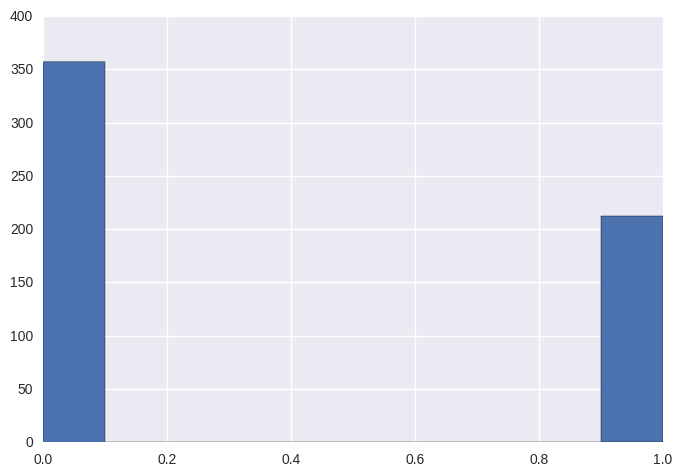

In [3]:
data['diagnosis'].hist()

In [4]:
# Wybieramy cechy
prediction_var = ['texture_mean','perimeter_mean','smoothness_mean','compactness_mean','symmetry_mean']
train, test = train_test_split(data, test_size = 0.3)# in this our main data is splitted into train and test
train_X = train[prediction_var][0:100]
train_y=train.diagnosis[0:100]
test_X= test[prediction_var] 
test_y =test.diagnosis  

In [5]:
# Regresja logistyczna
model = LogisticRegression(C=50)
model.fit(train_X,train_y)
pred = model.predict(test_X)
print metrics.accuracy_score(pred, test_y)
print metrics.precision_score(pred, test_y)
print metrics.recall_score(pred, test_y) 
print model.predict_proba(test_X)[:, 1]
print metrics.log_loss(test_y, model.predict_proba(test_X)[:, 1])

0.912280701754
0.823529411765
0.949152542373
[ 0.02563809  0.4613264   0.00823305  0.07471233  0.99980986  0.02474228
  0.27572887  0.00592868  0.01603427  0.99962514  0.32696137  0.00816692
  0.78332614  0.95556303  0.02490124  0.66682771  0.01233052  0.99999728
  0.00399793  0.38350235  0.02852429  0.36320807  0.00929038  0.01701881
  0.99797969  0.90977857  0.75399269  0.00304642  0.23666818  0.85564947
  0.00789699  0.04358578  0.13374829  0.99806151  0.09867065  0.99929724
  0.76204003  0.03448434  0.09314774  0.32739229  0.97964088  0.64867584
  0.82573046  0.01488733  0.34746296  0.11869637  0.01577449  0.99998684
  0.9881962   0.01977349  0.06357395  0.92333199  0.99177166  0.70663804
  0.14278978  0.03123441  0.00255886  0.05516198  0.45538581  0.98520439
  0.05528579  0.97326745  0.0420906   0.72849591  0.2033293   0.04083411
  0.00516843  0.9984388   0.00764448  0.04735068  0.22230288  0.08566867
  0.44110132  0.21298609  0.99357681  0.01533801  0.11437524  0.03470253
  0.04

## Zadanie 1 [3 pkt]

1. Powyższy model ma istotnie wyższy recall niż precision. 

Zdefiniujmy jako model probabilistyczny model, który zwraca p($\hat{y}$ | y). Obiekt LogisticRegression zwraca tą wartość funkcją ``predict_proba``

1. Każdy model probabilistyczny można użyć do stworzenia klasyfikora, która może mieć precision 100% lub recall 100% trywialnie, jak? 

2. Krzywa precision/recall jest obliczana licząc precision oraz recall modelu probabilistycznego dla różnych wartości precision. Zarysuj wykres precision/recall dla modelu powyżej.

Powinno wyjść:

<img src="figures/L7/prec_recall.png">

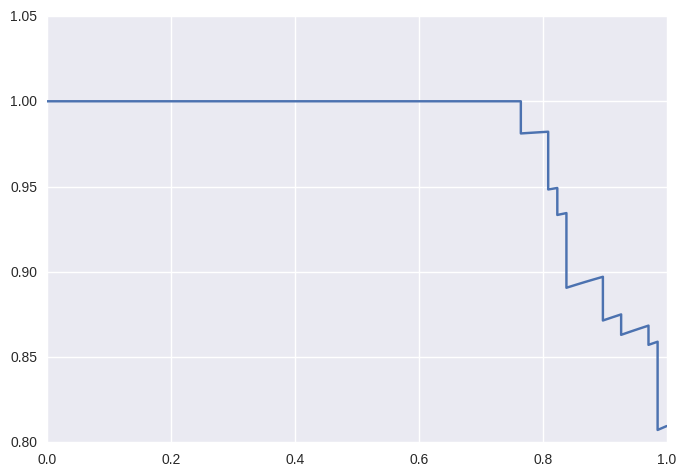

In [6]:
#1. 100% precision: zalozenie ze wszyscy sa zdrowi, 100% recall: zalozenie ze wszyscy sa chorzy
#2.
from sklearn.metrics import precision_recall_curve
predicted = model.predict_proba(test_X)
precision, recall, threshold = precision_recall_curve(test_y, predicted[:,1])
import matplotlib.pyplot as plt
plt.plot(recall, precision)
plt.show()

## Zadanie 2 [3 pkt]

Założmy, że $C_{FP}$ = 1 i $C_{FN}$ = 10, co odpowiada sytuacji w której nie przejmujemy się postawieniem fałszywej pozytywnej diagnozy.

Według http://web.cs.iastate.edu/~honavar/elkan.pdf wystarczy w takim wypadku dodać przykładom odpowiednią wage.

a) Przetestuj pare wag klasy negatywnej przez podanie argumentu class_weight do LogisticRegression. Dla każdej wartości wagi narysuj dokładność (accuracy) oraz wynik metryki FN_aversive. Powinno wyjść:

<img src="figures/L7/fn_aversive.png">

b) Równoważnym sposobem tworzenia "cost-sensitive" klasyfikatora z modelu probabilistycznego jest zmiana progu (patrz Zadanie 1). Znajdź taki próg, aby wynik klasyfikatora z tym progiem był równoważny argumentowi class_weight, który daje w punkcie a) najlepszy wynik.

Podpowiedź: Jeśli 2 sprawia problem, przejrzyj załączoną publikację

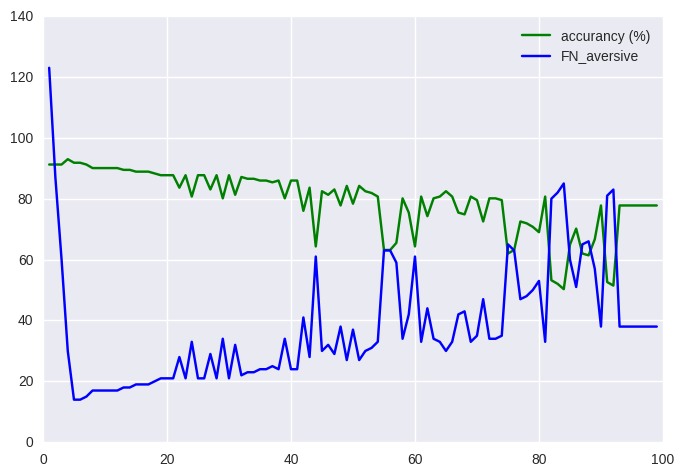

In [12]:
#a)
wagi=[]
accurancies = []
metryki_FN = []
for waga in range(1,100):
    wagi.append(waga)
    model = LogisticRegression(C=50, class_weight={0:1, 1:waga})
    model.fit(train_X,train_y)
    pred = model.predict(test_X)
    accurancies.append((metrics.accuracy_score(pred, test_y))*100)
    y_pred = model.predict(test_X)
    metryki_FN.append(FN_aversive(test_y, y_pred))
    
    

    
plt.plot(wagi,  accurancies,'g' ,label='accurancy (%)')
plt.plot(wagi, metryki_FN,'b' ,label = 'FN_aversive')
plt.legend()



    


In [8]:
def FN_aversive(y_true, y_pred):
    FN = sum((y_true == 1) * (y_pred != y_true))
    FP = sum((y_true == 0) * (y_pred != y_true))
    return 10 * FN + FP


# Metryki c.d. (model probabilistyczny)

Metryki wcześniej wprowadzone zakładają na wejściu klasyfikator, albo model probabilistyczny z dobranym na twardo thresholdem. Trochę bardziej skomplikowanym modelem może być model probabilistyczny, który zwraca jedynie prawdopodobieństwo

## Entropia krzyżowa/log loss (dla klasyfikacji binarnej)

Entropia krzyżowa, inaczej log loss jest niczym innym jak dobrze nam znanym log likelihood modelu zastosowanym do modeli probabilistycznych (zwracających prawdopodobieństwo):

$$ LL(\hat y, y) = CE(\hat y, y) = \sum_{i=1}^{N} y \log\hat(y) $$.

Entropia krzyżowa może być też bezpośrednio optymalizowana, w odróżnieniu od metryk typu accuracy, precision czy recall.

Warto wspomnieć, że niektóre modele mają dobre accuracy, ale słaby log loss (np. Naive Bayes).

## ROC

Krzywa ROC tworzona jest podobnie jak krzywa precision recall, tylko tym razem dla każdego progu liczymy true positive rate (p oraz false positive rate.

<img src="figures/L7/roc_curve.png">

Czasami chcemy opisać krzywą ROC jedną liczbą, z oczywistych względów musimy coś "oszukać" (tj. stracić jakąś informację). Popularny sposób to pole powierzni pod krzywą ROC

# Naive Bayes vs Regresja Logistyczna 

Ref: https://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf

## Wyprowadzenie

[Wyprowadzić na zajęciach]

**Wyprowadzenie zaczynamy od zdefiniowania procesu generowania danych**

### Naive Bayes

Zakładamy niezależność cech

$$ p(X | Y) = \prod_i P(X_i | Y) $$

### Regresja logistyczna (binarna)

Zdefiniujmy ``odds`` jako

$$ o = \frac{p(Y=1 | x)}{p(Y=0| x)} $$

Wtedy regresja logistyczna definiuje:

$$ \log(o) = \sum \theta_i x_i $$

**Teraz liczymy likelihood**

### Naive Bayes

Naive Bayes to model generatywny (co jak dowiemy się niedługo ma wady). Użyjmy reguły Bayesa aby policzyć likelihood:

$$ p(Y | X) = P(X | Y) P(Y)  = ( \prod_i P(X_i | Y)) P(Y) $$

### Regresja logistyczna

Przekształcając $$ \log(o) = \sum \theta_i x_i $$ otrzymujemy *bezpośrednio*, że $$ p(y | x) = \mbox{sigmoid}(\sum \theta_i x_i) $$, gdzie $sigmoid(a) = \frac{1}{1 + \exp(-a)}$.

## Różnice pomiędzy Naive Bayes a regresją logistyczną

### Niezależność cech

Naive Bayes zakłada niezależność cech (brak korekty liniowych zależności). Mówiąc inaczej możemy "wrzucić" do regresji logistycznej skorelowane cechy i się nic nie stanie. W przypadku modelu Naive Bayes nazywamy ten problem "double counting".


### Model dyskryminatywny vs generatywny

Przez model generatywny rozumiem model, który optymalizuje łączne prawdopodobieństwo p(x, y).

**Obserwacja 1.** Modelowanie p(x | y) lub p(x) nie jest bezpośrednio niezbędne do modelowania p(y | x). 

Obserwacja 1. mówi nam, że model generatywny wykonuje "dodatkową" pracę. W związku z tym czemu modele generatywne są aktywnie wykorzystywane w praktyce? Jest to po prostu kolejny sposób regularyzacji! Modelując p(x | y) można (niezbyt ściśle) powiedzieć, że modelujemy sposób w jaki funkcjonuje świat. Zainteresowanych odsyłamy do https://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf oraz [TODO]

Naive Bayes to *model generatywny*, a *regresja logistyczna* to model dyskryminatywny. W związku z tym należy oczekiwać, że w granicy danych regresja logistyczna będzie osiągać lepsze wyniki, ale może być różnie w przypadku małej ilości danych

<img src="figures/L7/ng_plot.png">

(Obrazek za https://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf).

### Log loss

Naive Bayes daje zbyt optymistyczne prawdopodobieństwa. Jest dobry w accuracy, ale zły w log lossie.

In [9]:
# Przykład słabego log lossu modelu Naive Bayes
model = GaussianNB()
model.fit(train_X,train_y)
pred = model.predict(test_X)
print metrics.accuracy_score(test_y, pred,)
print metrics.precision_score(test_y, pred)
print metrics.recall_score(test_y, pred)
# Regresja logistyczna osiąga 0.26
print metrics.log_loss(test_y, model.predict_proba(test_X)[:, 1])

0.918128654971
0.818181818182
0.964285714286
0.203777398379


## Zadanie 3 [3 pkt]

Naive Bayes jest często stosowany do problemów klasyfikacyjnych na tekście. W tym zadaniu zajmiemy się klasyfikacją SPAMU. Na wejściu zadany jest test wiadomości e-mail, etykietą jest 0 (prawdziwa wiadomość, "HAM") lub 1 (SPAM). 

Podstawowym problemem jest sposób reprezentacji tekstu. Podobnie jak w przypadku rozważanych funkcji bazowych na wcześniejszych zajęciach, modele wymagają stałowymiarowego wektoru. Proszę użyć klasy CountVectorizer z sklearn w celu przekształcenia wiadomości do reprezentacji wektorowej.

1. Zastosuj transformację tekstu do reprezentacji bag of words
2. Naucz model Naive Bayes (MultinomialNB) przewidywać SPAM
3. Pokaż problem "double counting" w modelu Naive Bayes. 

### Załadowanie danych

In [16]:
import collections, re
messages = pd.read_csv('data/SMSSpamCollection', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])



### Eksploracja danych

In [17]:
messages.groupby('label').describe()

message
label                                                          
ham   count                                                4827
      unique                                               4518
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

In [18]:
messages['length'] = messages['message'].map(lambda text: len(text))
print messages.head()

  label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61


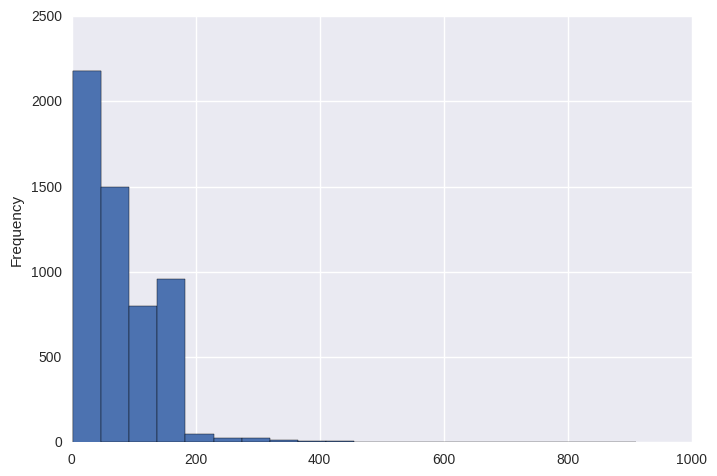

In [19]:
messages.length.plot(bins=20, kind='hist')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f715503a610>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f7155058c90>], dtype=object)

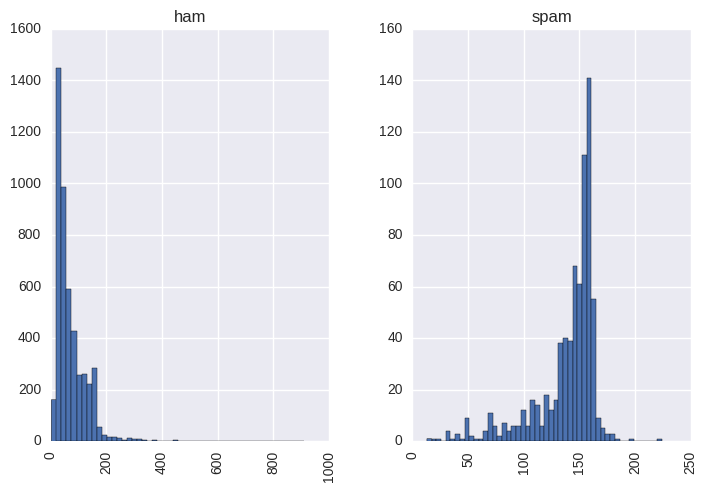

In [20]:
messages.hist(column='length', by='label', bins=50)

## Przetworzenie danych

In [112]:
import numpy as np

rozdzial = ' |\.$|\. |, |\/|\(|\)|\'|\"|\!|\?|\+'
messages_bow=[]
for i in range(len(messages['message'])):
    text = messages['message'][i]
    wtext = [w for w in re.split(rozdzial, text) if w]
    messages_bow.append(wtext)

messages_bow = np.matrix(messages_bow)
print 'sparse matrix shape:', messages_bow.shape
print 'number of non-zeros:', messages_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))

 sparse matrix shape: (1, 5574)
number of non-zeros:

AttributeError: 'matrix' object has no attribute 'nnz'

In [74]:
spam_detector = # Twoj kod

In [77]:
print 'accuracy', # Twoj kod
print 'confusion matrix\n', # Twoj kod

accuracy 0.993003229279
confusion matrix
[[4813   14]
 [  25  722]]
(row=expected, col=predicted)
